Notebook criado para o desenvolvimento de Machine Learning do projeto "Crimes em Chicago", produzido para a disciplina 'Projeto Integrador III', do curso de Tecnologia em Big Data para Negócios, da FATEC Ipiranga. 

Instala-se a biblioteca psycopg2, para a conexão do notebook com o banco de dados PostgreSQL no qual se encontra o data warehouse do projeto.

In [ ]:
%pip install psycopg2
%pip install statsmodels
%pip install scikit-learn
%pip install matplotlib

Após a instalação, importam-se as bibliotecas necessárias.

In [2]:
import psycopg2 as ps2 #para conexão do IPYNB com o DW
import pandas as pd #para manipulação dos dados extraídos do DW
import random #para uso na criação de datasets de sample
#para uso no machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#para uso nas previsões temporais
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
#para uso na regressão linear
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

Iniciam-se variáveis com os parametros necessários para a criação de uma string de conexão com o banco de dados.

In [ ]:
db_host = 'nome do servidor'
db_port = 'porta'
db_name = 'nome do database'
db_user = 'nome do usuario'
db_password = 'senha do usuario'

Criação da string de conexão, a partir dos parametros passados anteriormente.

In [39]:
conexao = ps2.connect(
    host=db_host,
    port=db_port,
    dbname=db_name,
    user=db_user,
    password=db_password
)

Transformação das tabelas do banco de dados em dataframes.

In [ ]:
query = "SELECT * FROM dim_Localizacao"
dfLocalizacao = pd.read_sql(query, conexao)

In [42]:
dfLocalizacao

,beat,distrito
0,111,1
1,112,1
2,113,1
3,114,1
4,121,1
...,...,...
270,2532,25
271,2533,25
272,2534,25
273,2535,25


In [ ]:
query = "SELECT * FROM dim_tipoCrime"
dfTipoCrime = pd.read_sql(query, conexao)

In [44]:
dfTipoCrime

,iucr,categoriacrime,descricaocrime
0,0110,HOMICIDE,FIRST DEGREE MURDER
1,0130,HOMICIDE,SECOND DEGREE MURDER
2,0141,HOMICIDE,INVOLUNTARY MANSLAUGHTER
3,0142,HOMICIDE,RECKLESS HOMICIDE
4,0261,CRIMINAL SEXUAL ASSAULT,AGGRAVATED - HANDGUN
...,...,...,...
405,5121,OTHER OFFENSE,ARSONIST - ANNUAL REGISTRATION
406,5122,OTHER OFFENSE,ARSONIST - FAIL TO REGISTER NEW ADDRESS
407,5130,OTHER OFFENSE,VIOLENT OFFENDER - DUTY TO REGISTER
408,5131,OTHER OFFENSE,VIOLENT OFFENDER - ANNUAL REGISTRATION


In [ ]:
query = "SELECT * FROM dim_Tempo"
dfTempo = pd.read_sql(query, conexao)


In [46]:
dfTempo

,datatempo,ano,mes,dia
0,2000-01-01,2000,1,1
1,2000-01-02,2000,1,2
2,2000-01-03,2000,1,3
3,2000-01-04,2000,1,4
4,2000-01-05,2000,1,5
...,...,...,...,...
9492,2025-12-27,2025,12,27
9493,2025-12-28,2025,12,28
9494,2025-12-29,2025,12,29
9495,2025-12-30,2025,12,30


In [ ]:
query = "SELECT * FROM fato_Casos ORDER BY RANDOM() LIMIT 10000" # selecionada apenas uma amostra da tabela original
dfCasos = pd.read_sql(query, conexao)

In [48]:
dfCasos

,idcasos,numerocaso,data,iucr,descricaolocal,prisao,domestico,beat,ala,areacomunitaria,dataultimaatualizacao,latitude,longitude,local
0,2571248,HJ159013,2003-02-01,1330,AIRPORT/AIRCRAFT,True,False,1651,41.0,76.0,2018-02-28,41.976290,-87.905227,"(41.976290414, -87.905227221)"
1,12657262,JF191726,2022-03-30,0910,STREET,False,False,111,42.0,32.0,2023-01-03,41.883475,-87.627877,"(41.883475491, -87.627876969)"
2,7482530,HS285208,2010-04-30,1310,RESIDENCE,False,False,631,8.0,44.0,2018-02-10,41.747060,-87.601427,"(41.747059617, -87.60142699)"
3,7089449,HR497829,2009-08-22,0810,STREET,False,False,922,11.0,60.0,2018-02-28,41.828665,-87.646513,"(41.828664934, -87.646512928)"
4,2725049,HJ354824,2003-05-08,0890,HOTEL/MOTEL,False,False,1834,42.0,8.0,2018-02-28,41.891679,-87.627552,"(41.891678767, -87.627551654)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11305143,JB250435,2018-05-04,1320,STREET,False,False,1414,35.0,22.0,2018-05-11,41.923813,-87.700954,"(41.923813323, -87.700954096)"
9996,11120881,JA474283,2017-10-17,2825,RESIDENCE,False,True,1523,28.0,25.0,2018-02-10,41.883137,-87.757611,"(41.883137142, -87.757610846)"
9997,6983833,HR388814,2009-06-22,0890,PARK PROPERTY,False,False,1632,36.0,17.0,2018-02-10,41.945400,-87.799970,"(41.945399848, -87.799970169)"
9998,7418494,HS216602,2010-03-19,0910,STREET,False,False,911,14.0,63.0,2018-02-10,41.798855,-87.685391,"(41.798854705, -87.685390881)"


Após os dados necessários serem extraídos, fecha-se a conexão com o banco de dados.

In [49]:
conexao.close()

**Previsão da probabilidade de prisões**

In [6]:
# criando um dataframe do resultado do join entre dfCasos e dfTipoCrime
casos_tipoCrime = dfCasos.merge(dfTipoCrime, left_on='IUCR', right_on='IUCR')

In [7]:
# funcao para previsao de probabilidade de prisao

def previsao_prisao(categoria,area):
  X = casos_tipoCrime[['categoriacrime', 'areacomunitaria']]
  y = casos_tipoCrime['prisao']

  # dividindo os dados em conjunto de treinamento e teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # criando um transformador para lidar com variáveis categóricas
  preprocessor = ColumnTransformer(
      transformers=[
          ('cat', OneHotEncoder(handle_unknown='ignore'), ['categoriacrime', 'areacomunitaria'])
      ])

  # criando o modelo de regressão logística
  model = Pipeline([
      ('preprocessor', preprocessor),
      ('classifier', LogisticRegression())
  ])

  # treinando o modelo
  model.fit(X_train, y_train)

  # criando um novo dataframe com os valores de categoriacrime e área comunitária
  new_data = pd.DataFrame({'categoriacrime': [categoria], 'areacomunitaria': [area]})

  # usando o modelo para prever a probabilidade de prisão
  probabilidade_prisao = model.predict_proba(new_data)[:, 1]

  print(f"The probability of arrest for {categoria.lower()} in the Community Area {int(area)} is {probabilidade_prisao[0]:.2%}.")

In [51]:
previsao_prisao('THEFT', 61.0)

The probability of arrest for theft in the Community Area 61 is 12.56%.


**Previsão de tendências temporais**

In [13]:
# contar quantidade de casos por dia e agrupar em um dataframe
date_counts = dfCasos['Data'].value_counts().reset_index()

# renomeando as colunas
date_counts.columns = ['Data', 'contagemCasos']

# ordenando pela data - ascendente
date_counts = date_counts.sort_values(by='Data')

# convertendo a coluna 'data' para o formato datetime
date_counts['Data'] = pd.to_datetime(date_counts['Data'])

# filtrar apenas datas a partir de outubro de 2002
date_counts_filtered = date_counts[date_counts['Data'] > '2002-09-30']

# indicar a coluna 'data' como índice
date_counts_filtered.set_index('Data', inplace=True)

# agrupar por mes
monthly_counts = date_counts_filtered.resample('M').sum()

# mostra o dataframe resultante
monthly_counts.head()


,contagemCasos
Data,
2002-10-31,38722
2002-11-30,32994
2002-12-31,34475
2003-01-31,33222
2003-02-28,30075


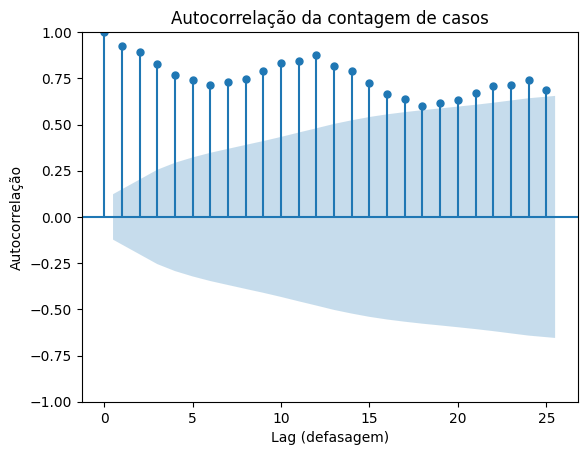

In [15]:
# plotar grafico de autocorrelacao
plot_acf(monthly_counts['contagemCasos'])
plt.title('Autocorrelação da contagem de casos')
plt.xlabel('Lag (defasagem)')
plt.ylabel('Autocorrelação')
plt.savefig('Documentação/Apresentação/autocorrelacao_contagem_casos.png', bbox_inches='tight')
plt.show()


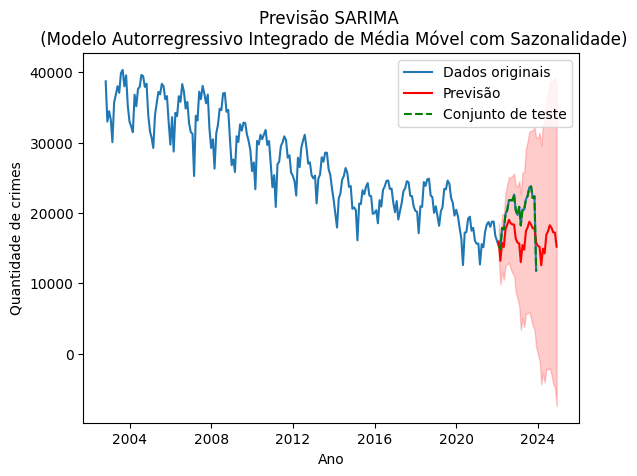

In [24]:
# Convertendo o índice para o tipo datetime se ainda não estiver
monthly_counts.index = pd.to_datetime(monthly_counts.index)

# Definindo a data de corte para o treinamento
cut_date = pd.to_datetime('2022-01-01')

# Separando os conjuntos de treinamento e teste
train = monthly_counts[monthly_counts.index < cut_date]
test = monthly_counts[monthly_counts.index >= cut_date]

# ajuste do modelo SARIMA (Modelo Autorregressivo Integrado de Média Móvel com Sazonalidade) no conjunto de treinamento
model = SARIMAX(train['contagemCasos'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# número de passos para prever até o final de 2024 (mensalmente)
forecast_steps = 12 * (2024 - monthly_counts.index[-1].year)

# criando índice de datas para a previsão, incluindo o período do conjunto de teste
forecast_index = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=len(test) + forecast_steps, freq='M')

# previsão de valores futuros
forecast = results.get_forecast(steps=len(test) + forecast_steps, index=forecast_index)

# obtenção dos valores de previsão e intervalos
forecast_values = forecast.predicted_mean
forecast_intervals = forecast.conf_int()

# plotagem dos dados originais, da previsão e do conjunto de teste
plt.plot(monthly_counts.index, monthly_counts['contagemCasos'], label='Dados originais')
plt.plot(forecast_values.index, forecast_values, color='red', label='Previsão')
plt.fill_between(forecast_intervals.index, forecast_intervals.iloc[:, 0], forecast_intervals.iloc[:, 1], color='red', alpha=0.2)
plt.plot(test.index, test['contagemCasos'], label='Conjunto de teste', linestyle='dashed', color='green')
plt.title('Previsão SARIMA \n (Modelo Autorregressivo Integrado de Média Móvel com Sazonalidade)')
plt.xlabel('Ano')
plt.ylabel('Quantidade de crimes')
plt.legend()
plt.savefig('Documentação/Apresentação/previsao_sarima.png', bbox_inches='tight')
plt.show()


Regressão Linear

In [8]:
hardship_index = pd.read_csv('C:/Users/51051056/Downloads/hardship_index.csv', sep=';')
hardship_index

,AreaComunitaria,hardshipindex
0,1,39
1,2,46
2,3,20
3,4,17
4,5,6
...,...,...
72,73,48
73,74,16
74,75,30
75,76,24


In [9]:
# Tranformação da variáveis em float
dfCasos['AreaComunitaria']=dfCasos['AreaComunitaria'].astype(float)
hardship_index['hardshipindex']=hardship_index['hardshipindex'].astype(float)

In [11]:
# Contagem 
area_counts = dfCasos['AreaComunitaria'].value_counts().reset_index()

# renomeando as colunas
area_counts.columns = ['AreaComunitaria', 'contagemCasos']
area_counts

,AreaComunitaria,contagemCasos
0,25.0,450103
1,8.0,254531
2,43.0,238624
3,23.0,219227
4,29.0,210226
...,...,...
73,12.0,13381
74,47.0,10832
75,36.0,9547
76,9.0,7130


In [12]:
# Merge
area_index = area_counts.merge(hardship_index, left_on='AreaComunitaria', right_on='AreaComunitaria')
area_index

,AreaComunitaria,contagemCasos,hardshipindex
0,25.0,450103,73.0
1,8.0,254531,1.0
2,43.0,238624,55.0
3,23.0,219227,85.0
4,29.0,210226,87.0
...,...,...,...
72,55.0,16086,44.0
73,12.0,13381,11.0
74,47.0,10832,79.0
75,36.0,9547,78.0


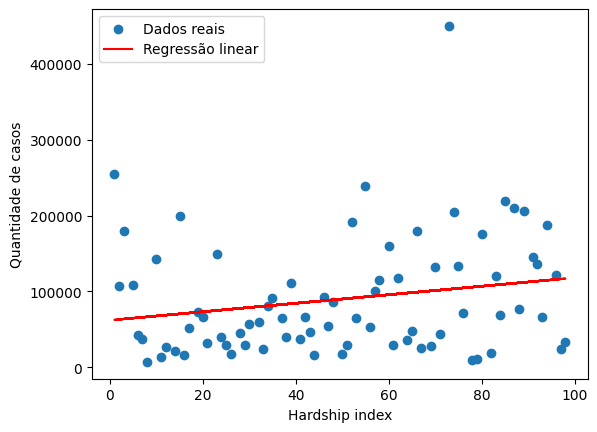

In [13]:
# Criando o modelo de regressão linear
model = LinearRegression()

# Treinando o modelo
model.fit(area_index['hardshipindex'].values.reshape(-1, 1), area_index['contagemCasos'])

# Fazendo previsões
predictions = model.predict(area_index['hardshipindex'].values.reshape(-1, 1)) 

# Visualizando os resultados
plt.scatter(area_index['hardshipindex'], area_index['contagemCasos'], label='Dados reais')
plt.plot(area_index['hardshipindex'], predictions, color='red', label='Regressão linear')
plt.xlabel('Hardship index')
plt.ylabel('Quantidade de casos')
plt.legend()
plt.show()